# **Association Rule Mining**

## Import Required Libraries

In [36]:
import pandas as pd
import matplotlib.pyplot as plt

from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules


# Dataset Preparation

## Load the Dataset

In [37]:
anime = pd.read_csv("dataset/anime.csv")
ratings = pd.read_csv("dataset/rating.csv")

## Basic Data Inspection

In [38]:
anime.head()
ratings.head()


,user_id,anime_id,rating
0,1,20,-1
1,1,24,-1
2,1,79,-1
3,1,226,-1
4,1,241,-1


In [39]:
anime.info()
print("\n")
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12294 entries, 0 to 12293
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   anime_id  12294 non-null  int64  
 1   name      12294 non-null  object 
 2   genre     12232 non-null  object 
 3   type      12269 non-null  object 
 4   episodes  12294 non-null  object 
 5   rating    12064 non-null  float64
 6   members   12294 non-null  int64  
dtypes: float64(1), int64(2), object(4)
memory usage: 672.5+ KB


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7813737 entries, 0 to 7813736
Data columns (total 3 columns):
 #   Column    Dtype
---  ------    -----
 0   user_id   int64
 1   anime_id  int64
 2   rating    int64
dtypes: int64(3)
memory usage: 178.8 MB


## Data Cleaning & Filtering

### Remove Unrated Entries
Ratings of -1 mean watched but not rated, may indicate user hasn't finished watching.

In [40]:
ratings = ratings[ratings['rating'] != -1]

### Keep Only “Liked” Anime
Association mining works best with positive interactions.

“Anime that users watched and liked"

In [41]:
ratings = ratings[ratings['rating'] >= 6]

### Filter users with low watched anime
- Remove one-time anime users
- Decrease Noise

Keeps:
- engaged users
- reasonable transaction size
- better co-occurrence patterns

In [ ]:
user_counts = ratings.groupby('user_id').size()
active_users = user_counts[user_counts >= 5].index
ratings = ratings[ratings['user_id'].isin(active_users)]

### Merge Anime Names
Convert into readable item names instead of IDs.

In [43]:
data = ratings.merge(
    anime[['anime_id', 'name']],
    on='anime_id'
)

data.head()

,user_id,anime_id,rating,name
0,3,20,8,Naruto
1,3,154,6,Shaman King
2,3,170,9,Slam Dunk
3,3,199,10,Sen to Chihiro no Kamikakushi
4,3,225,9,Dragon Ball GT


### Filter Popular Anime

Only count the top 100 anime to ease computation. 

Remove niche animes that are less frequently watched.

In [44]:
popular_anime = data['name'].value_counts().head(100).index
data_filtered = data[data['name'].isin(popular_anime)]

# Create Transaction Dataset

## Group Anime by User
Each user = one transaction

Each anime = one item

Example: User 123 → ["Naruto", "Bleach", "One Piece"]

In [45]:
from itertools import chain

# Convert to list of lists - makes computation faster
transactions = data_filtered.groupby('user_id')['name'].apply(list).tolist()

print("**** Transaction info ****")

print("Transactions:", len(transactions))
print("Avg items per transaction:", sum(len(t) for t in transactions) / len(transactions))
print("Unique items:", len(set(chain.from_iterable(transactions))))


**** Transaction info ****
Transactions: 60147
Avg items per transaction: 21.376610637272016
Unique items: 100


### Analyze transaction length statistics

In [46]:
# Compute transaction lengths per user
transaction_lengths = (
    data_filtered
    .groupby('user_id')['name']
    .count()
)

print("Transaction Length Statistics")
print(transaction_lengths.describe())

Transaction Length Statistics
count    60147.000000
mean        21.376611
std         16.939108
min          1.000000
25%          8.000000
50%         17.000000
75%         31.000000
max         99.000000
Name: name, dtype: float64


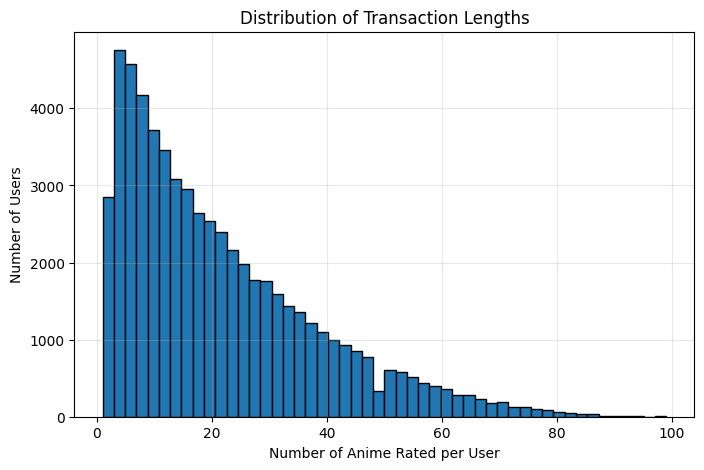

In [47]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.hist(transaction_lengths, bins=50, edgecolor='k')
plt.xlabel("Number of Anime Rated per User")
plt.ylabel("Number of Users")
plt.title("Distribution of Transaction Lengths")
plt.grid(alpha=0.3)
plt.show()

## One-Hot Encoding (TransactionEncoder)

In [48]:
te = TransactionEncoder()
te_array = te.fit(transactions).transform(transactions)

df_transactions = pd.DataFrame(te_array, columns=te.columns_)
df_transactions.head()

,Accel World,Akame ga Kill!,Angel Beats!,Ano Hi Mita Hana no Namae wo Bokutachi wa Mada Shiranai.,Another,Ao no Exorcist,Baccano!,Baka to Test to Shoukanjuu,Bakemonogatari,Black Lagoon,...,Tokyo Ghoul,Tokyo Ghoul √A,Tonari no Kaibutsu-kun,Tonari no Totoro,Toradora!,Trigun,Vampire Knight,Yahari Ore no Seishun Love Comedy wa Machigatteiru.,Zero no Tsukaima,Zero no Tsukaima: Futatsuki no Kishi
0,True,True,False,True,True,True,False,False,False,False,...,True,True,False,False,False,False,False,False,False,False
1,False,False,False,True,False,False,False,False,False,False,...,False,False,False,False,False,True,False,False,False,False
2,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,True,False,False,False,False,False,False


## Apply Apriori Algorithm

In [49]:
frequent_itemsets = apriori(
    df_transactions,
    min_support=0.02,
    use_colnames=True,
    max_len=2,
    low_memory=True
)

frequent_itemsets.sort_values(by='support', ascending=False).head()

,support,itemsets
24,0.546079,(Death Note)
81,0.405573,(Shingeki no Kyojin)
85,0.396728,(Sword Art Online)
19,0.392189,(Code Geass: Hangyaku no Lelouch)
2,0.377226,(Angel Beats!)


## Generate Association Rules

In [50]:
rules = association_rules(
    frequent_itemsets,
    metric="confidence",
    min_threshold=0.6
)

rules.sort_values(by='lift', ascending=False).head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
419,(Zero no Tsukaima: Futatsuki no Kishi),(Zero no Tsukaima),0.154156,0.197250,0.151080,0.980047,4.968553,1.0,0.120673,40.232959,0.944304,0.754170,0.975145,0.872989
418,(Zero no Tsukaima),(Zero no Tsukaima: Futatsuki no Kishi),0.197250,0.154156,0.151080,0.765931,4.968553,1.0,0.120673,3.613647,0.994997,0.754170,0.723271,0.872989
269,(Fate/Zero 2nd Season),(Fate/Zero),0.170366,0.199877,0.165827,0.973358,4.869786,1.0,0.131775,30.032457,0.957835,0.811224,0.966703,0.901502
268,(Fate/Zero),(Fate/Zero 2nd Season),0.199877,0.170366,0.165827,0.829646,4.869786,1.0,0.131775,4.870049,0.993162,0.811224,0.794663,0.901502
413,(Tokyo Ghoul √A),(Tokyo Ghoul),0.140389,0.237585,0.136067,0.969209,4.079427,1.0,0.102712,24.760907,0.878151,0.562474,0.959614,0.770959


## Filter out prequel - sequel v.v relationships
Association rule mining assumes: Items are independent entities

Sequels violate this assumption:

- Watching Season 2 almost requires watching Season 1

- Lift and confidence become inflated

- Rules become uninformative

### Normalize Anime Titles

In [51]:
import re

def normalize_title(title):
    title = title.lower()
    title = re.sub(r'\(.*?\)', '', title)   # remove parentheses
    title = re.sub(r'[^a-z0-9\s]', '', title)
    title = re.sub(r'\s+', ' ', title).strip()
    return title

### Detect Franchise Overlap

In [52]:
def is_sequel_pair(a, b):
    a_norm = normalize_title(a)
    b_norm = normalize_title(b)
    return a_norm in b_norm or b_norm in a_norm

### Filter Rules

In [53]:
def filter_sequel_rules(rules):
    mask = []
    for _, row in rules.iterrows():
        a = list(row['antecedents'])[0]
        b = list(row['consequents'])[0]
        mask.append(not is_sequel_pair(a, b))
    return rules[mask]

rules_clean = filter_sequel_rules(rules)

## Show Top Rules (by confidence)

In [54]:
top_rules = rules_clean[(rules_clean['lift'] > 1)].sort_values(
    by='confidence',
    ascending=False
)

top_rules.head(50)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
328,(Kiseijuu: Sei no Kakuritsu),(Shingeki no Kyojin),0.163150,0.405573,0.136283,0.835320,2.059606,1.0,0.070113,3.609599,0.614770,0.315148,0.722961,0.585673
6,(Accel World),(Sword Art Online),0.140655,0.396728,0.117096,0.832506,2.098430,1.0,0.061295,3.601751,0.609131,0.278611,0.722357,0.563831
398,(Tokyo Ghoul √A),(Shingeki no Kyojin),0.140389,0.405573,0.116415,0.829228,2.044583,1.0,0.059477,3.480819,0.594342,0.271017,0.712711,0.558133
390,(Tonari no Totoro),(Sen to Chihiro no Kamikakushi),0.170482,0.317040,0.141320,0.828945,2.614639,1.0,0.087271,3.992630,0.744454,0.408202,0.749539,0.637347
346,(Log Horizon),(Sword Art Online),0.152892,0.396728,0.126241,0.825685,2.081237,1.0,0.065584,3.460817,0.613283,0.298174,0.711051,0.571945
111,(Btooom!),(Sword Art Online),0.160490,0.396728,0.130563,0.813529,2.050597,1.0,0.066893,3.235214,0.610281,0.306017,0.690901,0.571315
12,(Akame ga Kill!),(Shingeki no Kyojin),0.170299,0.405573,0.138411,0.812750,2.003955,1.0,0.069342,3.174513,0.603816,0.316396,0.684991,0.577011
309,(Howl no Ugoku Shiro),(Sen to Chihiro no Kamikakushi),0.237169,0.317040,0.192545,0.811847,2.560710,1.0,0.117353,3.629816,0.798975,0.532386,0.724504,0.709584
254,(Death Parade),(Shingeki no Kyojin),0.145244,0.405573,0.117246,0.807234,1.990355,1.0,0.058339,3.083678,0.582128,0.270420,0.675712,0.548161
360,(Nisekoi),(Sword Art Online),0.138993,0.396728,0.112009,0.805861,2.031269,1.0,0.056867,3.107427,0.589655,0.264352,0.678190,0.544096


## Visualization

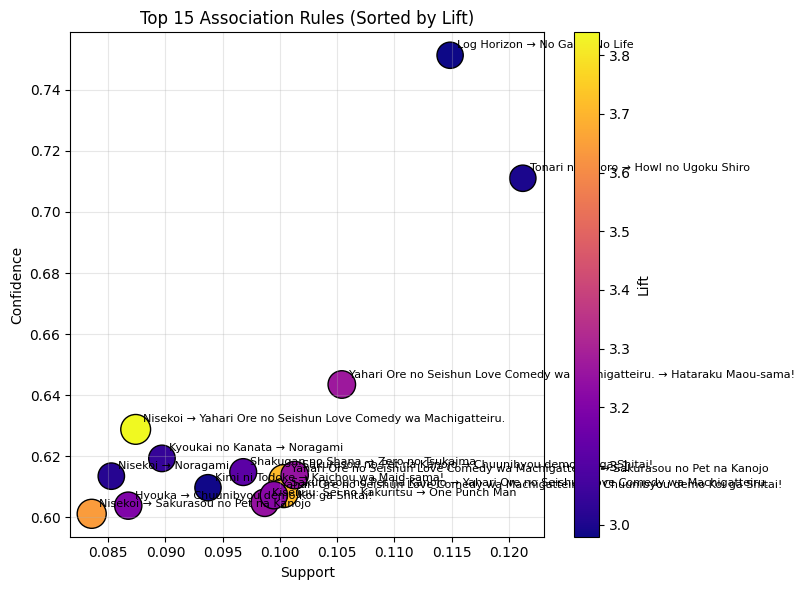

In [82]:
# Sort rules by lift, then confidence
rules_sorted = rules_clean.sort_values(
    by=['lift', 'confidence'],
    ascending=[False, False]
)

# Select top N rules
top_n = 15
rules_top = rules_sorted.head(top_n)

# Plot
plt.figure(figsize=(8,6))
plt.scatter(
    rules_top['support'],
    rules_top['confidence'],
    s=rules_top['lift'] * 120,
    c=rules_top['lift'],
    cmap='plasma',
    edgecolors='k'
)

# Annotate
for _, row in rules_top.iterrows():
    antecedent = ', '.join(row['antecedents'])
    consequent = ', '.join(row['consequents'])
    plt.annotate(
        f"{antecedent} → {consequent}",
        (row['support'], row['confidence']),
        fontsize=8,
        xytext=(5,5),
        textcoords='offset points'
    )

plt.xlabel('Support')
plt.ylabel('Confidence')
plt.title('Top 15 Association Rules (Sorted by Lift)')
plt.colorbar(label='Lift')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


## Selection of Top Association Rules

Intentionally use stricter thresholds to focus on strong, interpretable co-watching patterns rather than large volumes of weak rules.

In [80]:
# Filter strong, meaningful rules
final_rules = rules_clean[
    (rules_clean['support'] >= 0.15) &
    (rules_clean['confidence'] >= 0.75) &
    (rules_clean['lift'] > 1.5)
]

# Sort by lift first, then confidence
final_rules = final_rules.sort_values(
    by=['confidence', 'lift'],
    ascending=[False, False]
)

final_rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']].head(15)

,antecedents,consequents,support,confidence,lift
309,(Howl no Ugoku Shiro),(Sen to Chihiro no Kamikakushi),0.192545,0.811847,2.560710
397,(Tokyo Ghoul),(Shingeki no Kyojin),0.190650,0.802449,1.978557
372,(Noragami),(Shingeki no Kyojin),0.160490,0.788257,1.943565
292,(Guilty Crown),(Sword Art Online),0.150165,0.787377,1.984677
353,(Mononoke Hime),(Sen to Chihiro no Kamikakushi),0.174373,0.781986,2.466523
367,(No Game No Life),(Sword Art Online),0.195355,0.774708,1.952744
381,(Psycho-Pass),(Shingeki no Kyojin),0.150880,0.768482,1.894805
366,(No Game No Life),(Shingeki no Kyojin),0.191581,0.759742,1.873255


# Visualization of top association rules

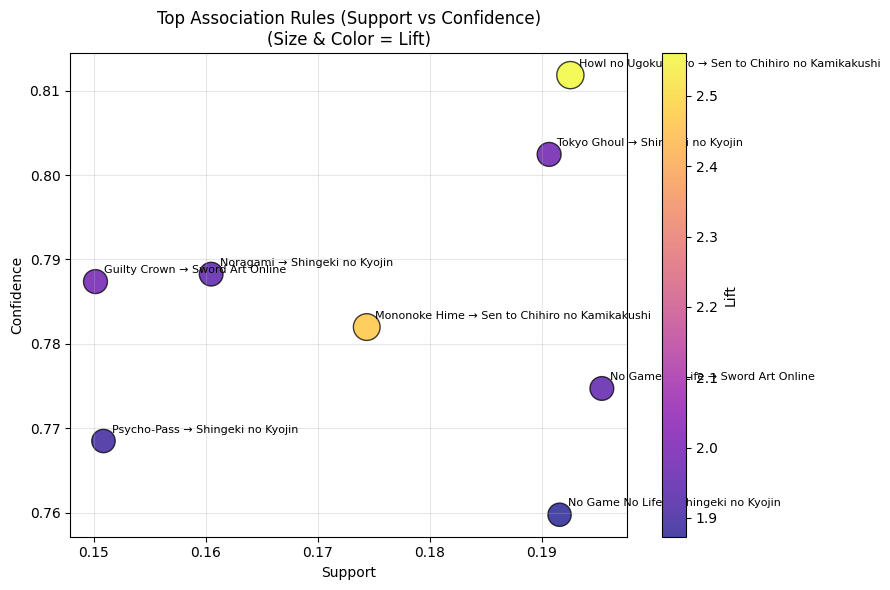

In [ ]:
# Select top N rules for visualization
top_n = 12
rules_vis = final_rules.head(top_n)

plt.figure(figsize=(9, 6))

scatter = plt.scatter(
    rules_vis['support'],
    rules_vis['confidence'],
    s=rules_vis['lift'] * 150,
    c=rules_vis['lift'],
    cmap='plasma',
    edgecolors='k',
    alpha=0.75
)

# Annotate points
for _, row in rules_vis.iterrows():
    a = ', '.join(row['antecedents'])
    b = ', '.join(row['consequents'])
    plt.annotate(
        f"{a} → {b}",
        (row['support'], row['confidence']),
        fontsize=8,
        xytext=(6,6),
        textcoords='offset points'
    )

plt.xlabel('Support')
plt.ylabel('Confidence')
plt.title('Top Association Rules (Support vs Confidence)\n(Size & Color = Lift)')
plt.colorbar(scatter, label='Lift')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Interpretation of Top rules (selected)

### Rule 1: Howl no Ugoku Shiro → Sen to Chihiro no Kamikakushi

This rule shows that users who highly rate Howl’s Moving Castle also tend to highly rate Spirited Away, with a confidence of 81.18% and a lift of 2.56. The high lift value indicates that this co-watching pattern occurs more than twice as often as would be expected by chance, suggesting a very strong association. Both films are produced by Studio Ghibli and share similar artistic style, themes, and emotional storytelling, which likely explains this strong overlap in viewer preferences. This rule highlights how shared studio identity and narrative tone can drive co-watching behavior, making it particularly valuable for recommendation systems.

### Rule 2: Tokyo Ghoul → Shingeki no Kyojin

This association reveals that users who rated Tokyo Ghoul also frequently rated Attack on Titan, with a confidence of 80.24% and a lift of 1.98. The high confidence indicates a strong likelihood that fans of darker, action-oriented anime are drawn to both titles. The lift value close to 2 suggests that this relationship is not merely due to overall popularity but reflects a genuine preference pattern among viewers. This rule demonstrates how thematic similarity, such as intense action, dark storytelling, and moral conflict, can influence co-watching behavior.

### Rule 3: No Game No Life → Sword Art Online

This rule indicates that users who enjoyed No Game No Life also tend to enjoy Sword Art Online, with a confidence of 77.47% and a lift of 1.95. Both anime revolve around immersive virtual or game-based worlds, which likely explains the strong association between them. While both titles are popular individually, the lift value confirms that their co-occurrence is significantly higher than random chance. This pattern suggests that viewers interested in game mechanics, fantasy settings, and strategic gameplay narratives often gravitate toward both series.

### Rule 4: Mononoke Hime → Sen to Chihiro no Kamikakushi

This rule shows a strong relationship between Princess Mononoke and Spirited Away, with a confidence of 78.20% and a lift of 2.47. Similar to the first rule, this association highlights the influence of Studio Ghibli’s storytelling style and thematic depth on viewer preferences. Despite being distinct films, their shared emphasis on environmental themes, character development, and artistic quality likely drives viewers to appreciate both titles. This rule further reinforces the impact of studio-driven identity on co-watching patterns.